# The purpose of this project is to conduct a sentiment analysis on tweets related to the 2022 World Cup using two different approaches: the Vader sentiment analysis tool and a pre-trained Roberta model from Hugging Face. This analysis aims to identify the overall sentiment of the tweets related to the World Cup, such as positive, negative or neutral, which could provide insights into how people feel about the event.

In [12]:
# !pip install gdown
!pip install transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # its used to create progress bars for the loops
from nltk import download
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
download(['punkt','vader_lexicon'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
!gdown 1QHkAS4LuCgD23XaIl-DB0HwbdrXQDqHt # downloading the dataset from my google drive. 
# if you prefer to load the data yourself: https://www.kaggle.com/datasets/tirendazacademy/fifa-world-cup-2022-tweets
df = pd.read_csv('fifa_world_cup_2022_tweets.csv') # Source: Kaggle.com
df.drop('Unnamed: 0',axis=1, inplace=True)
print('2022 Fifa worldcup tweets dataset with the shape of',df.shape)
df.sample(5)

Downloading...
From: https://drive.google.com/uc?id=1QHkAS4LuCgD23XaIl-DB0HwbdrXQDqHt
To: /content/fifa_world_cup_2022_tweets.csv
100% 4.55M/4.55M [00:00<00:00, 180MB/s]
2022 Fifa worldcup tweets dataset with the shape of (22524, 5)


,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
19995,2022-11-20 09:17:05+00:00,0,Twitter for iPhone,In the first of four 1st round matches today. ...,neutral
8624,2022-11-20 16:09:44+00:00,1,Twitter Web App,Why the hell was that goal disallowed!! #bbcfo...,negative
6431,2022-11-20 16:18:43+00:00,0,Twitter Web App,16' 0-1 GOAL! Valencia converts for Ecuador in...,neutral
514,2022-11-20 22:23:04+00:00,1,Twitter Web App,THE WORLD CUP OPENING CEREMONY ALREADY HAPPENE...,positive
15245,2022-11-20 14:58:27+00:00,6,Twitter for iPhone,WORLD CUP HERE WE GOOOOOOOO 🇦🇷 #WorldCup2022,positive


As we can see its already labeled so we can compare our results with the Sentiment column.

negative    5784
neutral     8251
positive    8489
Name: Sentiment, dtype: int64


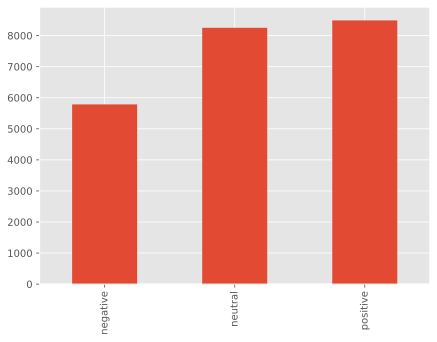

In [14]:
print(df['Sentiment'].value_counts().sort_index())
df['Sentiment'].value_counts().sort_index().plot(kind='bar',figsize=(7,5))
plt.show()

In [15]:
# tokens = df.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)

In [16]:
sia = SentimentIntensityAnalyzer()
res = []
for i, row in df.iterrows():
  text= row['Tweet']
  res.append(sia.polarity_scores(text))

In [17]:
# Initialize an empty list to store the sentiment classifications
sentclassify = []
# Iterate through the res list
for i in range(len(res)):
    # Get the current review from the res list
    review = res[i]
    # Check if the 'compound' attribute of the review is greater than or equal to 0.05
    if review['compound'] >= 0.05:
        # If the review is positive, append "positive" to the sentclassify list
        sentclassify.append("positive")
    # Check if the 'compound' attribute of the review is less than or equal to -0.05
    elif review['compound'] <= -0.05:
        # If the review is negative, append "negative" to the sentclassify list
        sentclassify.append("negative")
    # If the review is neither positive nor negative, append "neutral" to the sentclassify list
    else:
        sentclassify.append("neutral")

In [18]:
vader = pd.DataFrame(sentclassify)
df['vader'] = vader
df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,vader
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,neutral


In [19]:
df.Tweet[4]

'If the BBC cares so much about human rights, homosexual rights, and women rights then why not say these before the opening ceremony?? Why are they saying these during the opening ceremony?? Why did the BBC censor the #WorldCup2022 opening ceremony?? https://t.co/f72P03ZN2k'

One of the cons of vaders is that it doesn't understand relations between the words, for instance we have sarcastic phrases.

now i am going to go with roberta, a pre-trained model which has been trained on 58m tweets.

In [20]:
robertahuggingface = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(robertahuggingface)
tokenizer = AutoTokenizer.from_pretrained(robertahuggingface)

In [21]:
def polarity_scores_roberta(Input):
    # Tokenize the input text using the tokenizer
    encoded_text = tokenizer(Input, return_tensors='pt')
    # Pass the tokenized input to the model and get the output
    output = model(**encoded_text)
    # Extract the scores from the output and convert it to a NumPy array
    scores = output[0][0].detach().numpy()
    # Apply softmax on the scores to normalize them
    scores = softmax(scores)
    # Return the normalized scores
    return scores

In [22]:
df2 = df.head(500) # using only 500 observations for the roberta model otherwise it'll take forever to finish.
res = []
for i, row in tqdm(df2.iterrows(), total=len(df2)): 
  text= row['Tweet']
  res.append(polarity_scores_roberta(text))

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
roberta = []
for i in range(len(res)):
  argmax = np.argmax(res[i])
  if argmax == 0:
    roberta.append('negative')
  elif argmax == 1:
    roberta.append('neutral')
  else:
    roberta.append('positive')
df2['roberta'] = roberta
df2.sample(10)

<ipython-input-26-8465ff0e5128>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['roberta'] = roberta


,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,vader,roberta
375,2022-11-20 22:42:25+00:00,0,Twitter for Android,Everyone was proud \nThe best performance and ...,positive,positive,positive
392,2022-11-20 22:40:27+00:00,0,Twitter for iPad,Wonder if any #females took part at the openin...,neutral,neutral,neutral
359,2022-11-20 22:44:22+00:00,0,Twitter for Android,@FIFAWorldCup Never gonna happen again well do...,positive,positive,positive
65,2022-11-20 23:37:32+00:00,1,Twitter for iPhone,This celebration is breaking controllers in Fi...,positive,positive,positive
24,2022-11-20 23:50:22+00:00,0,Twitter for Android,Exciting things are happening at #Sporten head...,positive,positive,positive
458,2022-11-20 22:31:23+00:00,0,Twitter Web App,Alicia Keys Reportedly Pulled Out Of #WorldCup...,negative,positive,neutral
95,2022-11-20 23:27:13+00:00,0,Twitter Web App,@GBNEWS The complete unsuitability of #Qatar t...,negative,negative,negative
345,2022-11-20 22:45:14+00:00,0,Twitter for iPhone,Although I loved all of the opening ceremony o...,positive,positive,positive
273,2022-11-20 22:57:00+00:00,0,Twitter Web App,🏆World Cup 2022🏆 \n\nToday’s Matches: \n\n🔸Eng...,neutral,neutral,neutral
474,2022-11-20 22:29:27+00:00,0,IFTTT,Chelsea TV: Mason Mount | From Cobham to Qatar...,neutral,neutral,neutral


In [24]:
print('sentiment column\n',df2['Sentiment'].value_counts().sort_index(),'\n---')
print('vader model prediction\n',df2['vader'].value_counts().sort_index(),'\n---')
print('roberta model prediction\n',df2['roberta'].value_counts().sort_index())

sentiment column
 negative    126
neutral     201
positive    173
Name: Sentiment, dtype: int64 
---
vader model prediction
 negative    113
neutral     158
positive    229
Name: vader, dtype: int64 
---
roberta model prediction
 negative    127
neutral     219
positive    154
Name: roberta, dtype: int64
